
# BLLARSE: Optimizer × Batch Size Analysis (W&B)

This notebook pulls your runs from **Weights & Biases** and analyzes how **optimizer** and **batch size** affect the metrics:

- `loss`
- `nll` (negative log-likelihood)
- `acc` (accuracy)
- `ece` (expected calibration error)

It also produces **epoch-wise line plots** with **ribbon bands** (±1 std across seeds) to visualize training dynamics.

**Assumptions from your training code:**

- Project: `verses_ai/bllarse_experiments`
- Group: `sweep1_batchsize_by_optimizer`
- Config keys present per run: `dataset`, `batch_size`, `optimizer`, `seed`, `epochs`
- Logged metrics per epoch: `epoch`, `loss`, `nll`, `acc`, `ece`

> Tip: If you ran both CIFAR-10 and CIFAR-100, remember that your sweep logs **20 epochs** for CIFAR-10 and **40 epochs** for CIFAR-100 (based on your config generator).


In [1]:

# If needed, install dependencies (uncomment in your environment)
# %pip install --upgrade wandb pandas matplotlib pyarrow

import os
import math
import json
import time
from typing import Dict, Any, Iterable, List, Optional, Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import wandb

# (Optional) If WANDB_API_KEY is not set, you can run wandb.login() interactively.
if "WANDB_API_KEY" not in os.environ:
    print("WANDB_API_KEY not set; you can run `wandb.login()` in this notebook if needed.")
    # wandb.login()  # Uncomment to login interactively


WANDB_API_KEY not set; you can run `wandb.login()` in this notebook if needed.


In [2]:

# --- Configuration ---
ENTITY = "verses_ai"
PROJECT = "bllarse_experiments"
GROUP = "sweep1_batchsize_by_optimizer"   # filter by W&B "group"

# Optionally restrict to certain datasets (e.g., ["cifar10"] or ["cifar10","cifar100"]).
DATASETS: Optional[List[str]] = None  # None means "include all datasets"

# If you want to further restrict optimizers or batch sizes:
OPTIMIZERS: Optional[List[str]] = None   # e.g., ["adamw", "lion"]
BATCH_SIZES: Optional[List[int]] = None  # e.g., [512, 1024, 2048, 4096, 8192, 16384]

# Cache files so you don't re-download history every time
CACHE_DIR = "./wandb_cache"
os.makedirs(CACHE_DIR, exist_ok=True)
RUNS_CSV = os.path.join(CACHE_DIR, "runs_meta.csv")
HISTORY_PARQUET = os.path.join(CACHE_DIR, "history.parquet")

# For very large projects, you can limit runs during development:
MAX_RUNS: Optional[int] = None  # e.g., 40 or None for all


In [3]:

def _maybe(val, default=None):
    try:
        return val if val is not None else default
    except Exception:
        return default

def _get_cfg(run, key, default=None):
    try:
        return run.config.get(key, default)
    except Exception:
        return default

def list_runs(entity: str, project: str, group: str, datasets: Optional[List[str]] = None) -> List[wandb.apis.public.Run]:
    api = wandb.Api()
    filters = {"group": group}
    if datasets is not None:
        # W&B filter for any of a set of dataset values
        filters["$or"] = [{"config.dataset": ds} for ds in datasets]
    path = f"{entity}/{project}"
    runs = api.runs(path=path, filters=filters)
    return list(runs)

def run_meta_dict(run) -> Dict[str, Any]:
    return {
        "run_id": run.id,
        "name": run.name,
        "state": run.state,
        "created_at": str(run.created_at),
        "group": run.group,
        # Config
        "dataset": _get_cfg(run, "dataset"),
        "optimizer": _get_cfg(run, "optimizer"),
        "batch_size": _get_cfg(run, "batch_size"),
        "seed": _get_cfg(run, "seed"),
        "epochs_cfg": _get_cfg(run, "epochs"),
        # Summary (best by your define_metric; may be absent if run didn't finish)
        "summary_acc_best": run.summary.get("acc") if run.summary else None,
        "summary_loss_min": run.summary.get("loss") if run.summary else None,
        "summary_nll_min": run.summary.get("nll") if run.summary else None,
        "summary_ece_min": run.summary.get("ece") if run.summary else None,
    }

def fetch_history_dataframe(run, keys: Iterable[str]) -> pd.DataFrame:
    """
    Use scan_history to pull *all* rows for selected keys (safer than history(samples=...)).
    """
    rows = []
    for row in run.scan_history(keys=list(keys)):
        rows.append(row)
    if not rows:
        return pd.DataFrame(columns=list(keys))
    df = pd.DataFrame(rows)
    # ensure numeric
    for k in keys:
        if k in df.columns:
            df[k] = pd.to_numeric(df[k], errors="coerce")
    return df

def compile_histories(runs: List[wandb.apis.public.Run], 
                      keys: Iterable[str] = ("epoch", "loss", "nll", "acc", "ece"),
                      max_runs: Optional[int] = None) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Returns:
      meta_df: per-run metadata
      hist_df: concatenated per-epoch history with run metadata columns
    """
    meta_records = []
    hist_frames = []

    selected = runs[:max_runs] if (max_runs is not None) else runs
    for i, r in enumerate(selected, start=1):
        m = run_meta_dict(r)
        meta_records.append(m)

        hist = fetch_history_dataframe(r, keys)
        if len(hist) == 0:
            continue
        hist["run_id"] = r.id
        hist["dataset"] = m["dataset"]
        hist["optimizer"] = m["optimizer"]
        hist["batch_size"] = m["batch_size"]
        hist["seed"] = m["seed"]
        hist["state"] = m["state"]
        hist_frames.append(hist)

    meta_df = pd.DataFrame(meta_records)
    hist_df = pd.concat(hist_frames, ignore_index=True) if hist_frames else pd.DataFrame(columns=list(keys)+["run_id","dataset","optimizer","batch_size","seed","state"])
    return meta_df, hist_df


In [4]:

# --- Fetch data ---
runs = list_runs(ENTITY, PROJECT, GROUP, datasets=DATASETS)
if MAX_RUNS is not None:
    runs = runs[:MAX_RUNS]
print(f"Found {len(runs)} runs in W&B for group='{GROUP}' (entity/project: {ENTITY}/{PROJECT}).")

meta_df, hist_df = compile_histories(runs, keys=("epoch","loss","nll","acc","ece"), max_runs=MAX_RUNS)

# Optional local cache (for convenience)
if len(meta_df) > 0:
    meta_df.to_csv(RUNS_CSV, index=False)
if len(hist_df) > 0:
    try:
        hist_df.to_parquet(HISTORY_PARQUET, index=False)
    except Exception as e:
        print(f"Could not save parquet: {e}. Falling back to CSV.")
        hist_df.to_csv(HISTORY_PARQUET.replace(".parquet", ".csv"), index=False)

print("Meta shape:", meta_df.shape, "History shape:", hist_df.shape)
display(meta_df.head(10))
display(hist_df.head(10))


Found 120 runs in W&B for group='sweep1_batchsize_by_optimizer' (entity/project: verses_ai/bllarse_experiments).
Meta shape: (120, 14) History shape: (7200, 11)


,run_id,name,state,created_at,group,dataset,optimizer,batch_size,seed,epochs_cfg,summary_acc_best,summary_loss_min,summary_nll_min,summary_ece_min
0,8b9ehwa9,crimson-leaf-2918,finished,2025-09-04T15:47:45Z,sweep1_batchsize_by_optimizer,cifar10,lion,512,1,20,0.8978,0.571568,0.305494,0.006152
1,meqjf5u5,blooming-morning-2918,finished,2025-09-04T15:47:45Z,sweep1_batchsize_by_optimizer,cifar10,lion,512,3,20,0.8975,0.571915,0.309270,0.008383
2,t0my92il,super-brook-2918,finished,2025-09-04T15:47:45Z,sweep1_batchsize_by_optimizer,cifar10,lion,512,4,20,0.8963,0.577467,0.309136,0.009655
3,9n25xr8w,dainty-terrain-2918,finished,2025-09-04T15:47:45Z,sweep1_batchsize_by_optimizer,cifar10,lion,512,0,20,0.8974,0.574334,0.309222,0.008516
4,7rj2cj39,dainty-snowball-2918,finished,2025-09-04T15:47:45Z,sweep1_batchsize_by_optimizer,cifar10,lion,512,2,20,0.8998,0.574297,0.308018,0.009290
5,zxng3m14,lilac-smoke-2923,finished,2025-09-04T15:47:46Z,sweep1_batchsize_by_optimizer,cifar10,adamw,512,0,20,0.8989,0.577578,0.309127,0.010062
6,fxyqwcra,lucky-wildflower-2924,finished,2025-09-04T15:47:48Z,sweep1_batchsize_by_optimizer,cifar10,adamw,512,3,20,0.8986,0.575587,0.304903,0.005868
7,zk2hxtgf,good-voice-2924,finished,2025-09-04T15:47:48Z,sweep1_batchsize_by_optimizer,cifar10,lion,1024,0,20,0.8976,0.567393,0.308321,0.009127
8,ruuxn320,worldly-terrain-2924,finished,2025-09-04T15:47:48Z,sweep1_batchsize_by_optimizer,cifar10,lion,1024,2,20,0.8994,0.571461,0.307418,0.008458
9,ee7d8dy0,curious-durian-2925,finished,2025-09-04T15:47:48Z,sweep1_batchsize_by_optimizer,cifar10,adamw,512,1,20,0.8990,0.575884,0.303117,0.007943


,epoch,loss,nll,acc,ece,run_id,dataset,optimizer,batch_size,seed,state
0,1,1.404785,0.470388,0.8694,0.092634,8b9ehwa9,cifar10,lion,512,1,finished
1,1,1.404785,0.470388,0.8694,0.092634,8b9ehwa9,cifar10,lion,512,1,finished
2,1,0.793874,0.362074,0.8855,0.022059,8b9ehwa9,cifar10,lion,512,1,finished
3,2,0.793874,0.362074,0.8855,0.022059,8b9ehwa9,cifar10,lion,512,1,finished
4,1,0.738255,0.348221,0.8915,0.030451,8b9ehwa9,cifar10,lion,512,1,finished
5,3,0.738255,0.348221,0.8915,0.030451,8b9ehwa9,cifar10,lion,512,1,finished
6,1,0.682183,0.327379,0.8949,0.020652,8b9ehwa9,cifar10,lion,512,1,finished
7,4,0.682183,0.327379,0.8949,0.020652,8b9ehwa9,cifar10,lion,512,1,finished
8,1,0.637797,0.315348,0.8955,0.009214,8b9ehwa9,cifar10,lion,512,1,finished
9,5,0.637797,0.315348,0.8955,0.009214,8b9ehwa9,cifar10,lion,512,1,finished


In [5]:

# --- Cleanup / Optional Filters ---
# Keep rows with valid epoch and basic metadata
hist_df = hist_df.dropna(subset=["epoch"])
# Optional additional filters
if OPTIMIZERS is not None:
    hist_df = hist_df[hist_df["optimizer"].isin(OPTIMIZERS)]
    meta_df  = meta_df[meta_df["optimizer"].isin(OPTIMIZERS)]
if BATCH_SIZES is not None:
    hist_df = hist_df[hist_df["batch_size"].isin(BATCH_SIZES)]
    meta_df  = meta_df[meta_df["batch_size"].isin(BATCH_SIZES)]
if DATASETS is not None:
    hist_df = hist_df[hist_df["dataset"].isin(DATASETS)]
    meta_df  = meta_df[meta_df["dataset"].isin(DATASETS)]

hist_df["epoch"] = hist_df["epoch"].astype(int)

print("After filters → Meta shape:", meta_df.shape, "History shape:", hist_df.shape)
display(meta_df.groupby(["dataset","optimizer","batch_size"]).size().rename("num_runs").reset_index().head(20))


After filters → Meta shape: (120, 14) History shape: (7200, 11)


,dataset,optimizer,batch_size,num_runs
0,cifar10,adamw,512,5
1,cifar10,adamw,1024,5
2,cifar10,adamw,2048,5
3,cifar10,adamw,4096,5
4,cifar10,adamw,8192,5
5,cifar10,adamw,16384,5
6,cifar10,lion,512,5
7,cifar10,lion,1024,5
8,cifar10,lion,2048,5
9,cifar10,lion,4096,5


In [7]:

# --- Final-epoch metrics per run ---
# For each run_id, take the last epoch row (highest epoch)
hist_sorted = hist_df.sort_values(["run_id", "epoch"])
final_per_run = hist_sorted.groupby("run_id").tail(1).copy()
assert {"dataset","optimizer","batch_size","seed"}.issubset(final_per_run.columns)

# --- Best-by-summary per run ---
# Your training set define_metric(summary=...) should populate run.summary
# captured earlier in meta_df as summary_* columns.
best_summary = meta_df[["run_id","dataset","optimizer","batch_size","seed",
                        "summary_acc_best","summary_loss_min","summary_nll_min","summary_ece_min"]].copy()

# --- Aggregate across seeds: mean ± std ---
def agg_mean_std(df: pd.DataFrame, value_col: str, group_cols: List[str]) -> pd.DataFrame:
    g = df.groupby(group_cols)[value_col].agg(["mean","std","count"]).reset_index()
    g.rename(columns={"mean": f"{value_col}_mean", "std": f"{value_col}_std", "count": f"{value_col}_n"}, inplace=True)
    return g

group_cols = ["dataset","optimizer","batch_size"]
metrics = ["loss","nll","acc","ece"]

# Final epoch aggregates
final_aggs = []
for m in metrics:
    final_aggs.append(agg_mean_std(final_per_run, m, group_cols))
final_agg = final_aggs[0]
for a in final_aggs[1:]:
    final_agg = final_agg.merge(a, on=group_cols, how="outer")

# Best (summary) aggregates
best_aggs = []
best_map = {"summary_loss_min":"loss", "summary_nll_min":"nll", "summary_acc_best":"acc", "summary_ece_min":"ece"}
for col, base in best_map.items():
    best_aggs.append(agg_mean_std(best_summary, col, group_cols))
best_agg = best_aggs[0]
for a in best_aggs[1:]:
    best_agg = best_agg.merge(a, on=group_cols, how="outer")

print("Final-epoch (mean±std across seeds)")
display(final_agg.sort_values(group_cols).head(20))

print("Best-by-summary (mean±std across seeds)")
display(best_agg.sort_values(group_cols).head(20))


Final-epoch (mean±std across seeds)


,dataset,optimizer,batch_size,loss_mean,loss_std,loss_n,nll_mean,nll_std,nll_n,acc_mean,acc_std,acc_n,ece_mean,ece_std,ece_n
0,cifar10,adamw,512,0.576881,0.001829,5,0.306372,0.002627,5,0.89874,0.000940,5,0.007432,0.001648,5
1,cifar10,adamw,1024,0.576093,0.003537,5,0.305578,0.002441,5,0.89920,0.001834,5,0.009038,0.003094,5
2,cifar10,adamw,2048,0.590075,0.019938,5,0.308798,0.002295,5,0.89832,0.001462,5,0.012820,0.001091,5
3,cifar10,adamw,4096,0.596004,0.001701,5,0.314008,0.001187,5,0.89792,0.001871,5,0.019144,0.001547,5
4,cifar10,adamw,8192,0.637909,0.003803,4,0.331143,0.003243,4,0.89365,0.001021,4,0.026663,0.000948,4
5,cifar10,adamw,16384,0.696413,0.002247,5,0.359170,0.003857,5,0.88832,0.000879,5,0.037072,0.001944,5
6,cifar10,lion,512,0.573916,0.002369,5,0.308228,0.001614,5,0.89776,0.001274,5,0.008399,0.001363,5
7,cifar10,lion,1024,0.572877,0.007065,5,0.308445,0.003318,5,0.89888,0.001654,5,0.008379,0.001439,5
8,cifar10,lion,2048,0.611737,0.021260,5,0.316926,0.000939,5,0.89434,0.000934,5,0.007527,0.001984,5
9,cifar10,lion,4096,0.725802,0.002936,5,0.359282,0.001901,5,0.88818,0.001035,5,0.031545,0.000757,5


Best-by-summary (mean±std across seeds)


,dataset,optimizer,batch_size,summary_loss_min_mean,summary_loss_min_std,summary_loss_min_n,summary_nll_min_mean,summary_nll_min_std,summary_nll_min_n,summary_acc_best_mean,summary_acc_best_std,summary_acc_best_n,summary_ece_min_mean,summary_ece_min_std,summary_ece_min_n
0,cifar10,adamw,512,0.576881,0.001829,5,0.306372,0.002627,5,0.89874,0.000940,5,0.007432,0.001648,5
1,cifar10,adamw,1024,0.576093,0.003537,5,0.305578,0.002441,5,0.89920,0.001834,5,0.009038,0.003094,5
2,cifar10,adamw,2048,0.590075,0.019938,5,0.308798,0.002295,5,0.89832,0.001462,5,0.012820,0.001091,5
3,cifar10,adamw,4096,0.596004,0.001701,5,0.314008,0.001187,5,0.89792,0.001871,5,0.019144,0.001547,5
4,cifar10,adamw,8192,0.637727,0.003319,5,0.330445,0.003213,5,0.89394,0.001097,5,0.026596,0.000835,5
5,cifar10,adamw,16384,0.696413,0.002247,5,0.359170,0.003857,5,0.88832,0.000879,5,0.037072,0.001944,5
6,cifar10,lion,512,0.573916,0.002369,5,0.308228,0.001614,5,0.89776,0.001274,5,0.008399,0.001363,5
7,cifar10,lion,1024,0.572877,0.007065,5,0.308445,0.003318,5,0.89888,0.001654,5,0.008379,0.001439,5
8,cifar10,lion,2048,0.611737,0.021260,5,0.316926,0.000939,5,0.89434,0.000934,5,0.007527,0.001984,5
9,cifar10,lion,4096,0.725802,0.002936,5,0.359282,0.001901,5,0.88818,0.001035,5,0.031545,0.000757,5


In [8]:

# --- Plotting helpers (Matplotlib only; no seaborn) ---
def _as_array(x):
    return np.asarray(x, dtype=float)

def plot_metric_vs_batchsize(summary_df: pd.DataFrame, dataset: str, metric: str, *, use_best: bool = False):
    """
    Plot metric (mean ± std across seeds) vs batch_size, with one line per optimizer.
    X-axis is on log scale. Uses either final-epoch aggregates or best-by-summary aggregates.
    """
    if use_best:
        # best-by-summary columns are prefixed
        col_mean = f"summary_{metric}_min_mean" if metric in ("loss","nll","ece") else f"summary_{metric}_best_mean"
        col_std  = f"summary_{metric}_min_std"  if metric in ("loss","nll","ece") else f"summary_{metric}_best_std"
        # If the column names are not present (depending on mapping above), fall back to a generic search:
        if col_mean not in summary_df.columns or col_std not in summary_df.columns:
            # Try to infer
            candidates_mean = [c for c in summary_df.columns if c.endswith(f"{metric}_mean")]
            candidates_std  = [c for c in summary_df.columns if c.endswith(f"{metric}_std")]
            if len(candidates_mean) == 1 and len(candidates_std) == 1:
                col_mean, col_std = candidates_mean[0], candidates_std[0]
    else:
        col_mean = f"{metric}_mean"
        col_std  = f"{metric}_std"

    df = summary_df.copy()
    df = df[df["dataset"] == dataset]
    if df.empty:
        print(f"No data for dataset={dataset}")
        return

    optimizers = sorted(df["optimizer"].dropna().unique())
    plt.figure(figsize=(7, 5))
    for opt in optimizers:
        sub = df[df["optimizer"] == opt].sort_values("batch_size")
        if sub.empty:
            continue
        x = _as_array(sub["batch_size"])
        y = _as_array(sub[col_mean])
        s = _as_array(sub[col_std])

        plt.plot(x, y, marker="o", label=str(opt))
        if np.isfinite(s).any():
            ylo = y - s
            yhi = y + s
            plt.fill_between(x, ylo, yhi, alpha=0.2)

    plt.xscale("log")
    plt.xlabel("Batch size (log scale)")
    plt.ylabel(metric)
    plt.title(f"{dataset} — {metric} vs batch size (mean ± std across seeds)")
    plt.legend(title="optimizer")
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_epoch_curves(hist_df: pd.DataFrame, dataset: str, optimizer: str, metric: str, batch_sizes: Optional[List[int]] = None):
    """
    For a given dataset & optimizer, plot epoch-wise mean ± std across seeds for each batch size.
    Each batch size is a separate line with a ribbon.
    """
    sub = hist_df[(hist_df["dataset"] == dataset) & (hist_df["optimizer"] == optimizer)].copy()
    if batch_sizes is not None:
        sub = sub[sub["batch_size"].isin(batch_sizes)]
    if sub.empty:
        print(f"No data for dataset={dataset}, optimizer={optimizer}")
        return

    bs_values = sorted(sub["batch_size"].dropna().unique())
    plt.figure(figsize=(7, 5))
    for bs in bs_values:
        cur = sub[sub["batch_size"] == bs]
        # mean ± std across seeds at each epoch
        g = cur.groupby("epoch")[metric].agg(["mean","std","count"]).reset_index().sort_values("epoch")
        x = _as_array(g["epoch"])
        y = _as_array(g["mean"])
        s = _as_array(g["std"])
        plt.plot(x, y, label=f"bs={int(bs)}")
        if np.isfinite(s).any():
            ylo = y - s
            yhi = y + s
            plt.fill_between(x, ylo, yhi, alpha=0.2)

    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.title(f"{dataset} — {optimizer}: {metric} over epochs (mean ± std across seeds)")
    plt.legend(title="batch size")
    plt.grid(True, alpha=0.3)
    plt.show()


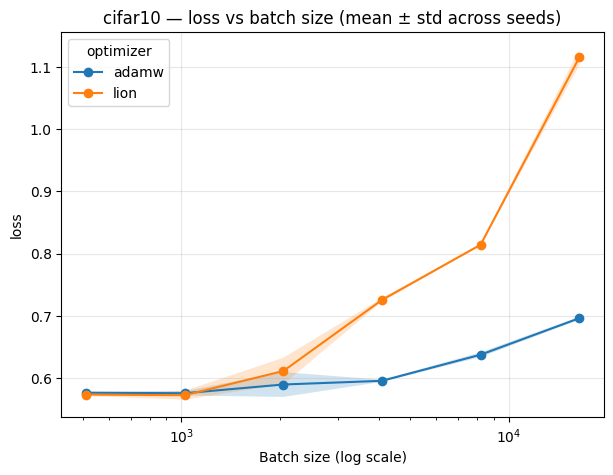

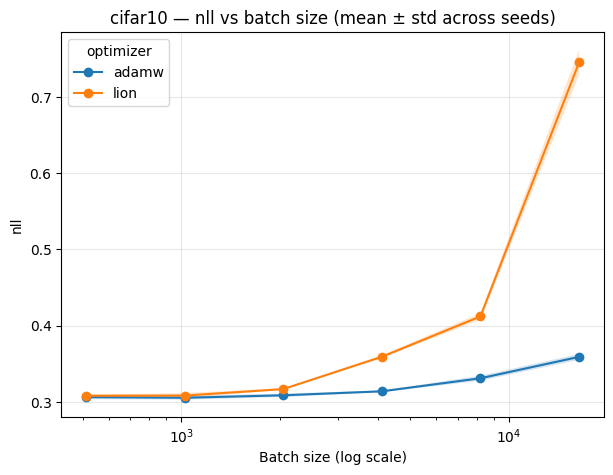

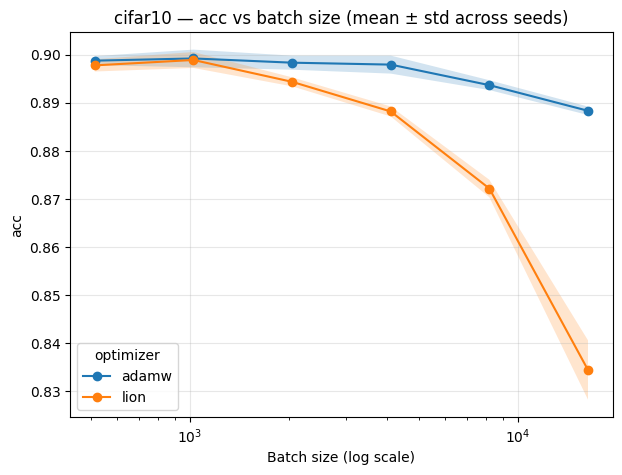

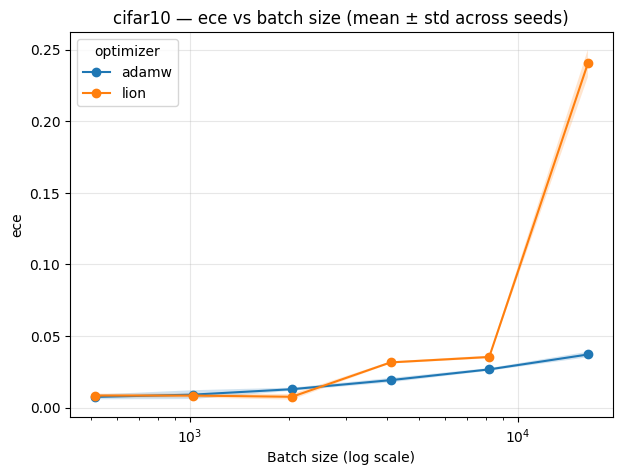

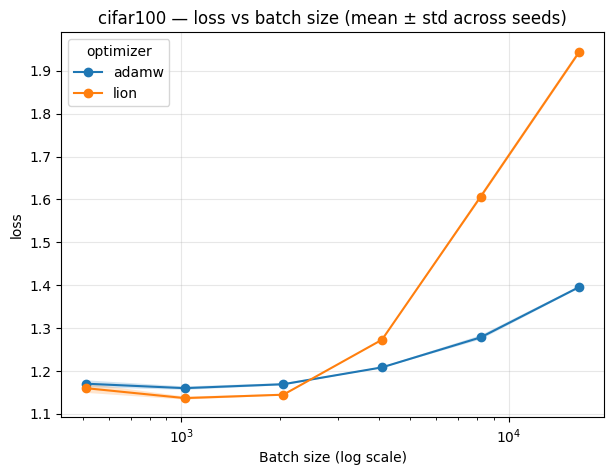

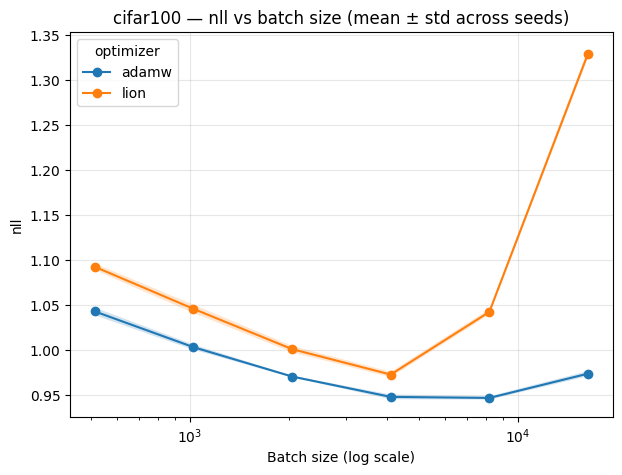

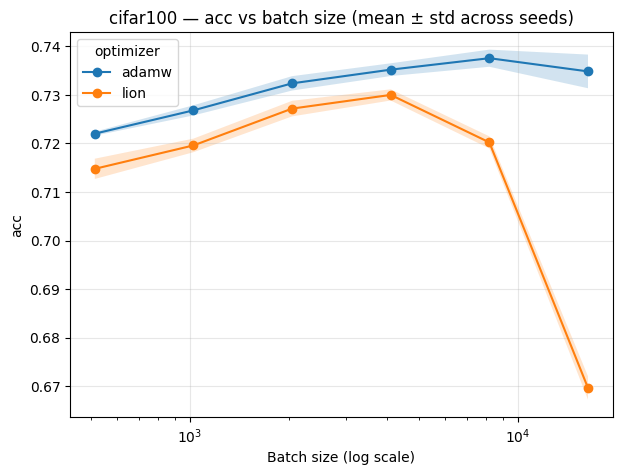

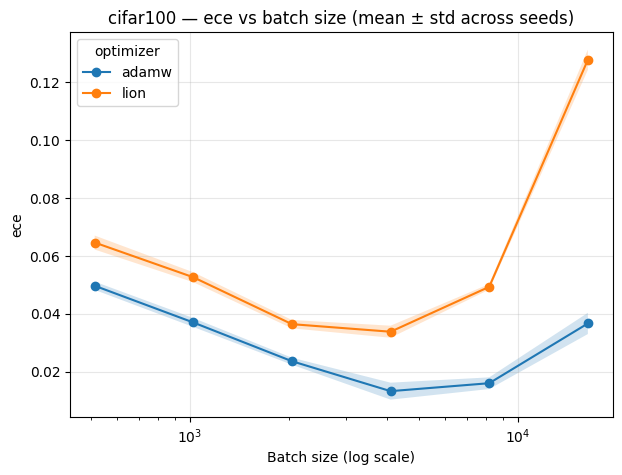

In [9]:

# --- Final-epoch summary plots (by dataset & metric) ---
datasets = sorted(final_agg["dataset"].dropna().unique())
metrics = ["loss", "nll", "acc", "ece"]

for ds in datasets:
    for m in metrics:
        plot_metric_vs_batchsize(final_agg, dataset=ds, metric=m, use_best=False)


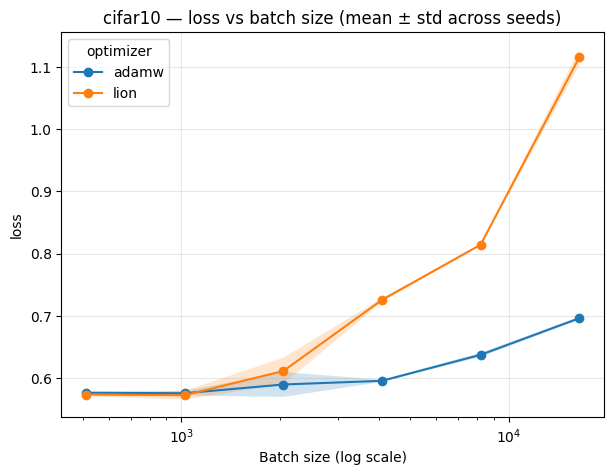

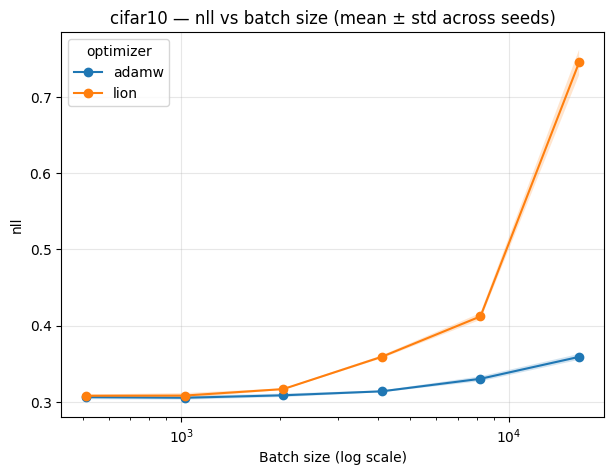

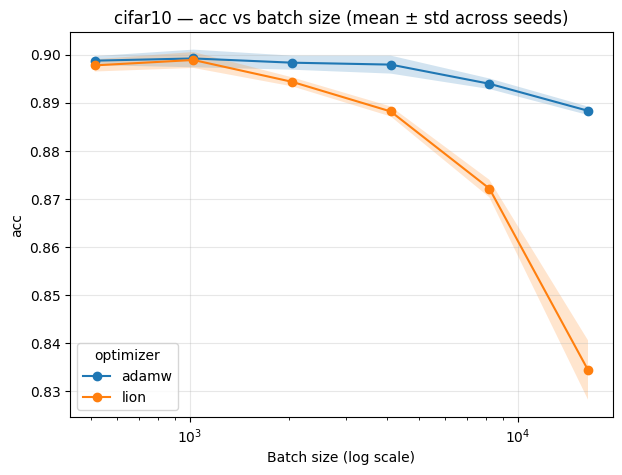

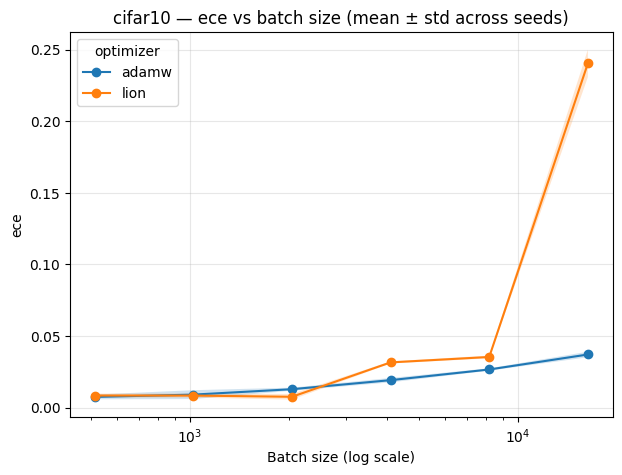

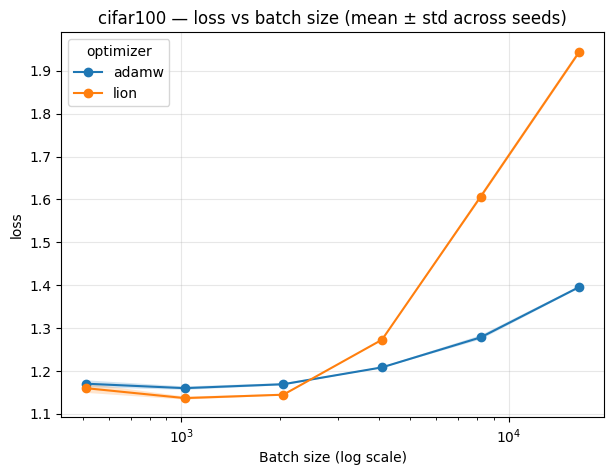

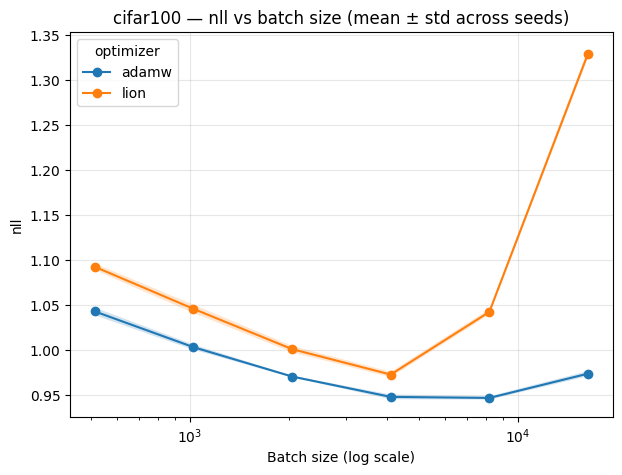

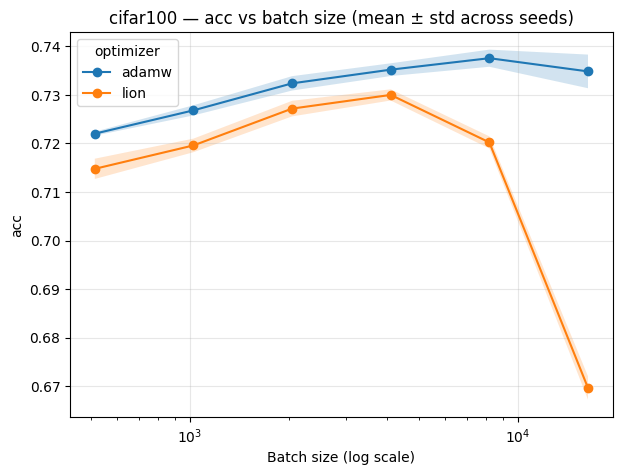

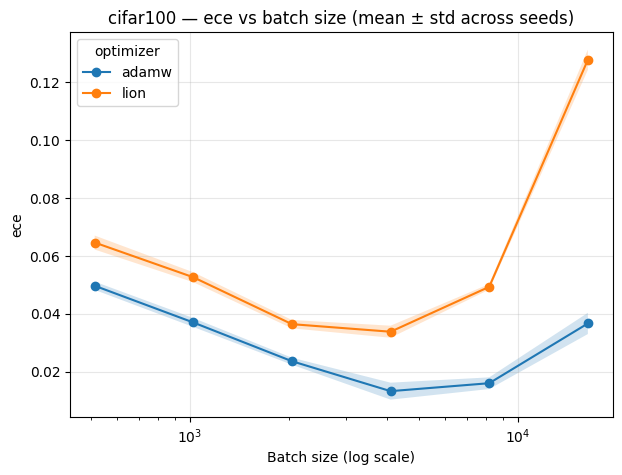

In [10]:

# --- Best-by-summary (as defined in W&B) plots ---
# This uses the per-run summary (min for loss/nll/ece; max for acc) aggregated across seeds.
for ds in sorted(best_agg["dataset"].dropna().unique()):
    for m in ["loss", "nll", "acc", "ece"]:
        plot_metric_vs_batchsize(best_agg, dataset=ds, metric=m, use_best=True)


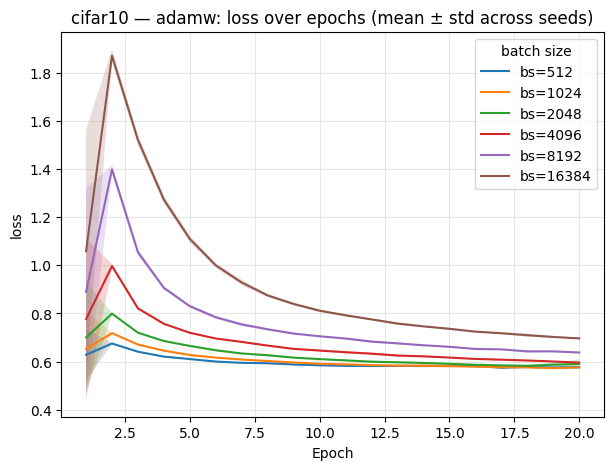

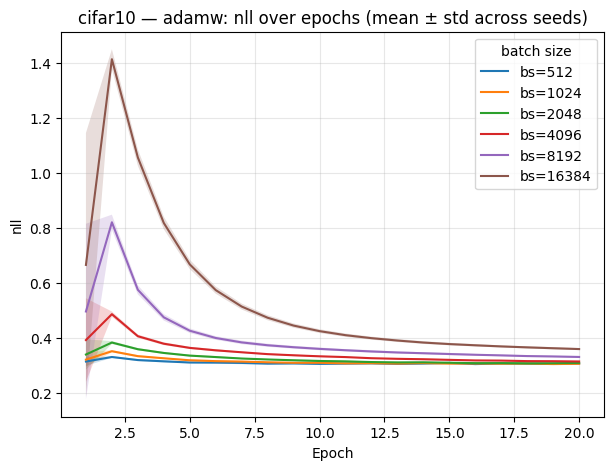

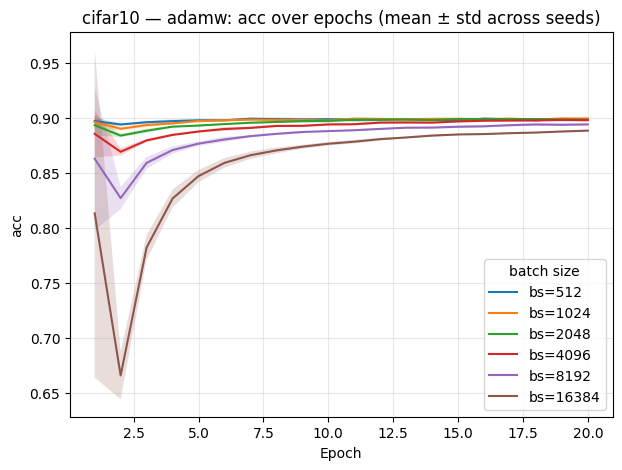

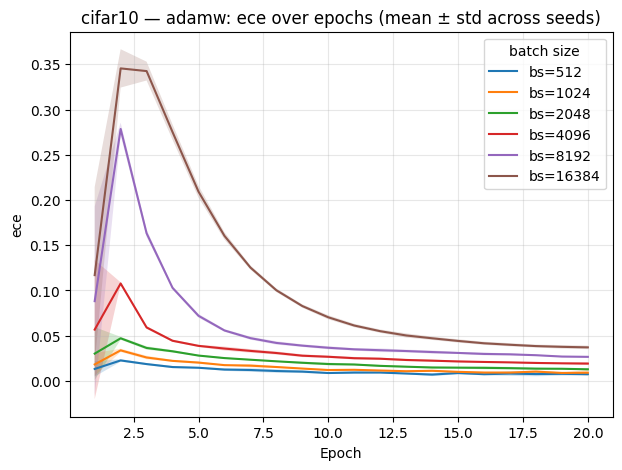

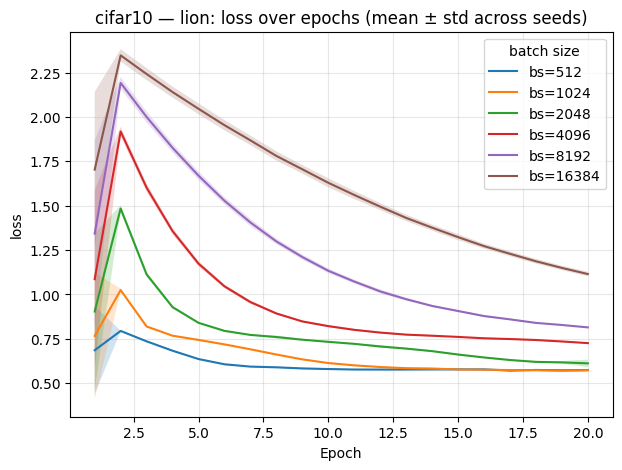

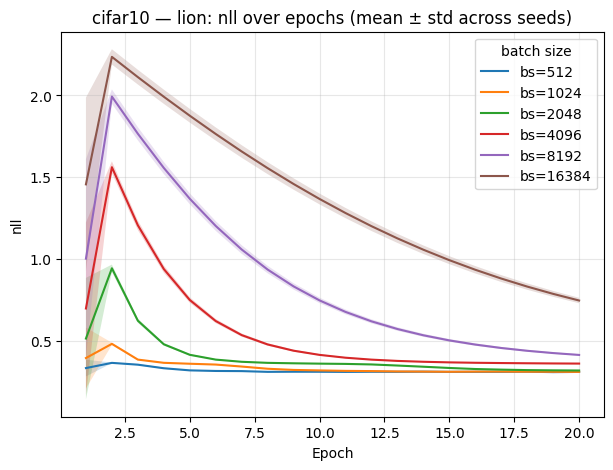

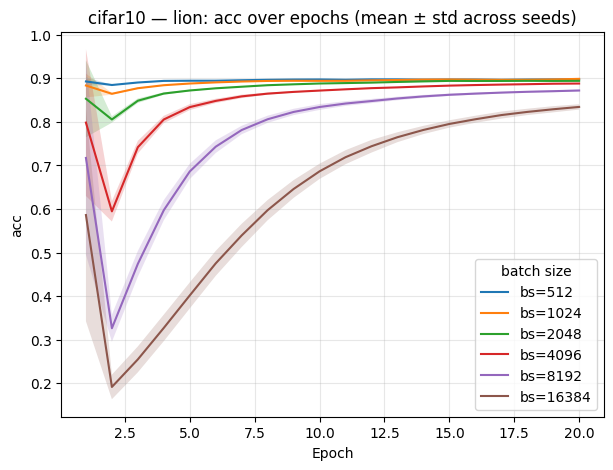

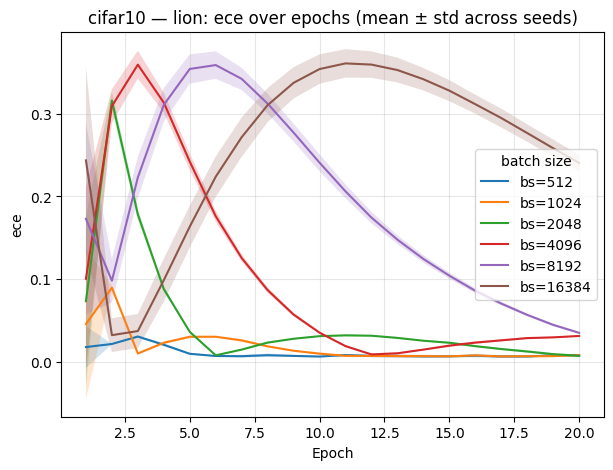

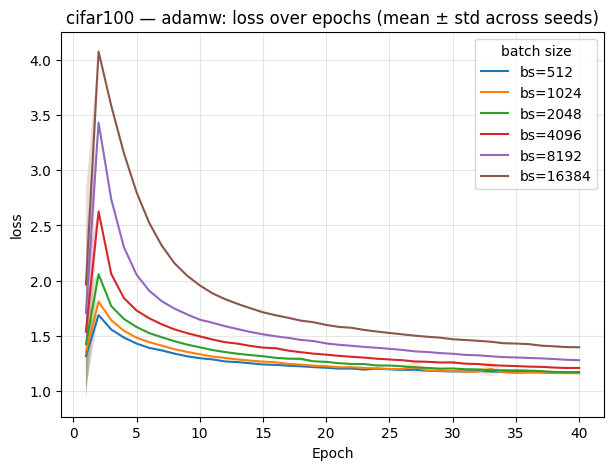

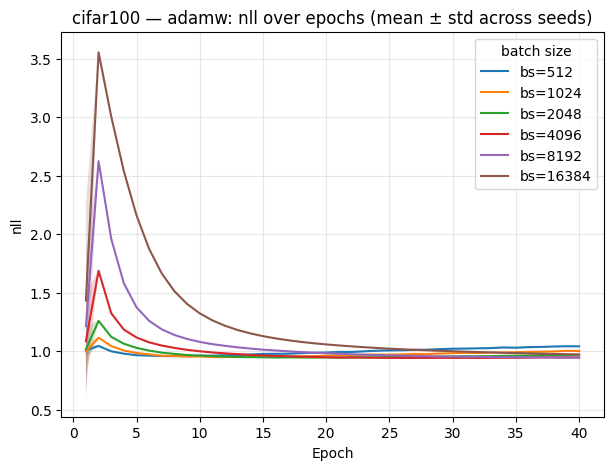

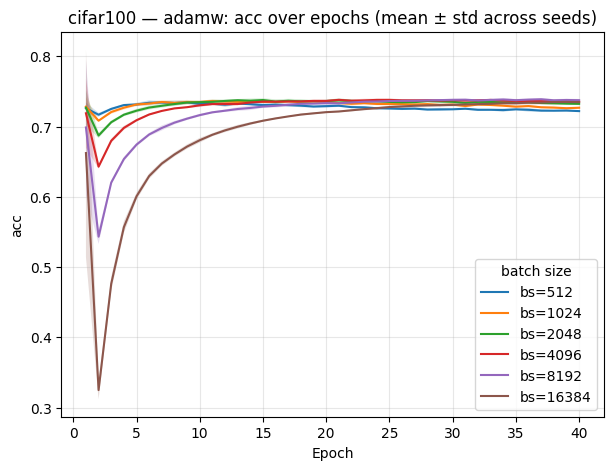

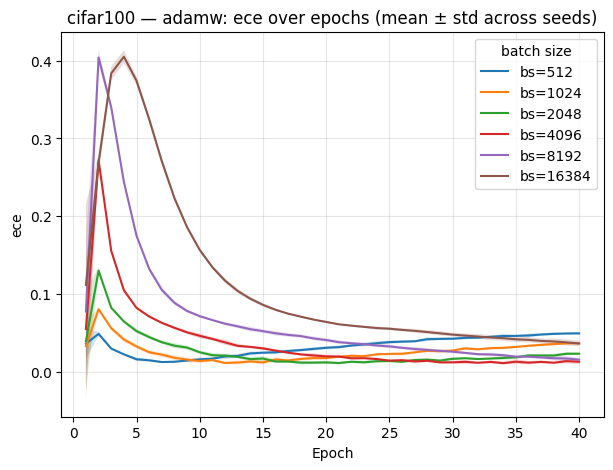

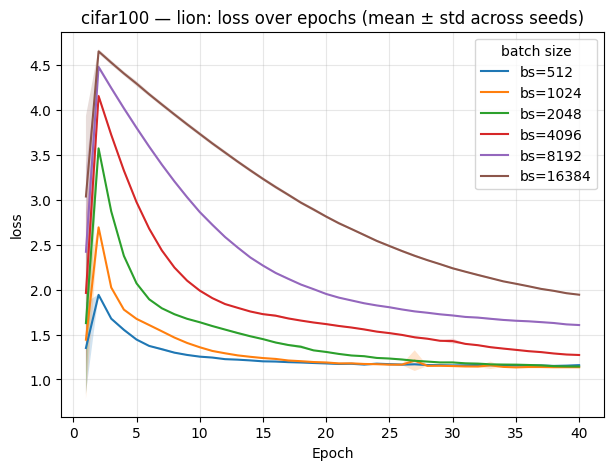

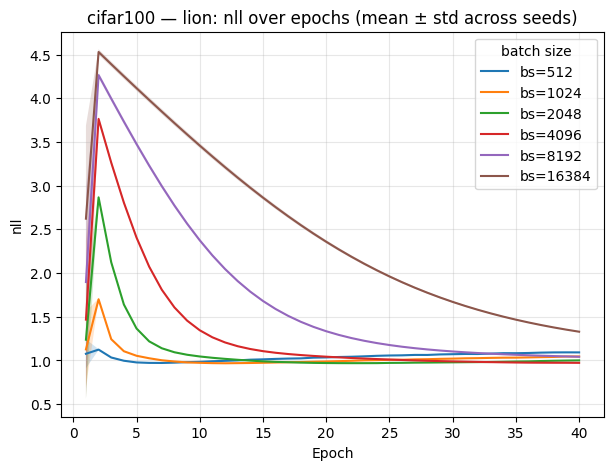

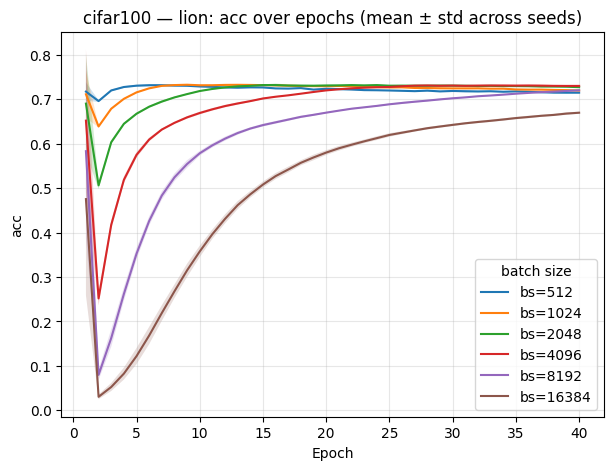

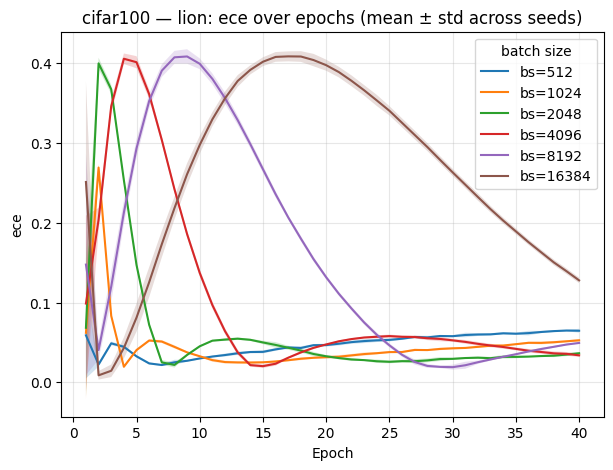

In [11]:

# --- Epoch-wise ribbon plots (mean ± std across seeds) ---
# This may produce many figures (datasets × optimizers × 4 metrics)
datasets = sorted(hist_df["dataset"].dropna().unique())
optimizers = sorted(hist_df["optimizer"].dropna().unique())
metrics = ["loss", "nll", "acc", "ece"]

for ds in datasets:
    for opt in optimizers:
        for m in metrics:
            plot_epoch_curves(hist_df, dataset=ds, optimizer=opt, metric=m, batch_sizes=None)  # or restrict batch_sizes=[512, 1024, ...]



## (Optional) Simple regression-style analysis

The code below fits a basic OLS model to **final-epoch** metrics to quantify the effects of optimizer,
batch size (log scale), and their interaction. This is optional and requires `statsmodels`.


In [ ]:

# %pip install statsmodels  # uncomment if needed

try:
    import statsmodels.formula.api as smf
    import statsmodels.api as sm

    df = final_per_run.merge(
        meta_df[["run_id","dataset","optimizer","batch_size","seed"]],
        on="run_id", how="left"
    ).dropna(subset=["optimizer","batch_size","dataset"])
    df["log2_bs"] = np.log2(df["batch_size"]).astype(float)

    # One model per dataset & metric
    for ds in sorted(df["dataset"].unique()):
        print(f"\n### OLS on dataset = {ds}")
        sub = df[df["dataset"] == ds]
        for metric in ["loss","nll","acc","ece"]:
            print(f"\n--- Metric: {metric} ---")
            try:
                model = smf.ols(formula=f"{metric} ~ C(optimizer) * log2_bs", data=sub).fit()
                print(model.summary().as_text())
            except Exception as e:
                print(f"Could not fit model for {metric}: {e}")
except Exception as e:
    print("statsmodels not available or failed:", e)
